# TP2 : Estimation de densité par noyaux

## Introduction à l'estimation statistique - G3 SDIA

Dans le cadre de cours, nous avons étudié jusqu'à présent des méthodes d'estimation dites paramétriques : on se fixe une famille de lois paramétrique à laquelle la loi ayant généré les données est censée appartenir, puis on cherche à estimer les paramètres à partir des données (par exemple par maximum de vraisemblance).

Dans ce TP, nous introduisons une méthode d'estimation **non-paramétrique** de la fonction de densité appelée estimation par noyaux (*kernel estimation* en anglais). C'est-à-dire que nous ne faisons plus d'hypothèse sur la loi ayant généré les données, et nous cherchons plutôt à estimer directement la densité de la loi parente $f$ (que l'on supposera continue). Ainsi cette méthode ne concerne que les variables aléatoires continues.

### Instructions

1. Renommer votre notebook sous la forme `tp2_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 22 Octobre 2023, 23h59.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

### Partie 1 - Histogrammes

On considère $(x_1, ..., x_n)$ $n$ réalisations indépendantes d'une variable aléatoire réelle.

Soit $x_0 \in \mathbb{R}$ et $h > 0$. On partitionne la droite réelle en intervalles de même longueur $h$, aussi appelés *bins* :
$$\forall k \in \mathbb{Z},~B_k =~]x_0 + (k-1)h~;~x_0 + kh].$$

L'histogramme est une fonction constante par morceaux définie de la manière suivante :
$$\forall x \in B_k,~H_n(x) = n_k,$$
où $n_k$ est le nombre de réalisations appartenant à l'intervalle $B_k$.

**Q1**. Comment normaliser $H_n$ pour obtenir un estimateur de la fonction de densité ? On rappelera que $\int_{\mathbb{R}} f(x) dx = 1$.

Dans la suite, on note $\hat{f}_n$ cet estimateur de $f$.

Pour tout $x \in \mathbb{R}$, calculer le biais et la variance de $\hat{f}_n(x)$. Commenter.


----- Votre réponse ici -----

**Q2**. On fixe $x_0 = \min_i x_i$. La valeur de $h$ peut être fixée indirectement en fixant à la place le nombre de *bins* $N_b$ entre $\min_i x_i$ et $\max_i x_i$, on a alors
$$h = \frac{\max_i x_i - \min_i x_i}{N_b}.$$

Générer 200 points d'un modèle de mélange gaussien à 2 composantes avec $\mu_1 = -2.5, \mu_2 = 1.5, \sigma_1 = \sigma_2 = 1, \pi_1 = 0.4, \pi_2 = 0.6$.

Montrer l'influence de la valeur de $h$ sur l'histogramme (normalisé). On utilisera la fonction $\texttt{np.histogram}$ pour calculer automatiquement les $n_k$, et la fonction $\texttt{plt.bar}$ pour représenter $\hat{f}_n$. Superposer la densité théorique du modèle de mélange gaussien.

On pourra afficher plusieurs histogrammes obtenus avec différentes valeurs de $N_b$ à l'aide de $\texttt{plt.subplots}$. Commenter.

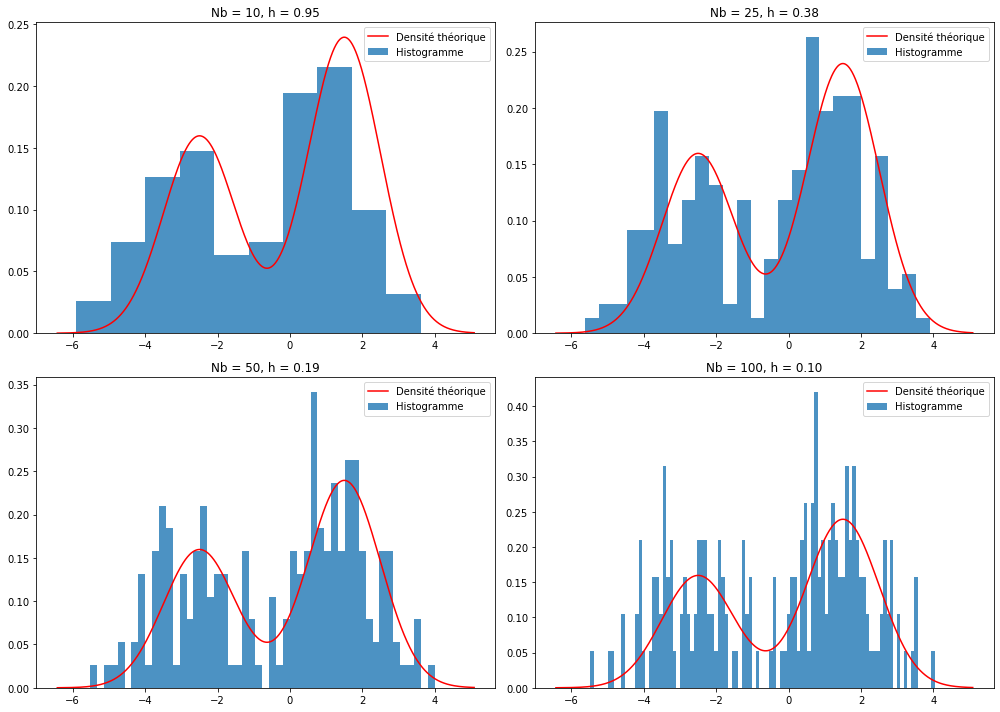

In [21]:
# Generate data from GMM

N = 200

# Paramètres du modèle de mélange gaussien
mu1, mu2 = -2.5, 1.5
sigma1, sigma2 = 1, 1
pi1, pi2 = 0.4, 0.6

N1 = int(N * pi1) #80
N2 = N - N1       #120

samples1 = np.random.normal(mu1, sigma1, N1)
samples2 = np.random.normal(mu2, sigma2, N2)
samples = np.concatenate([samples1, samples2])

#print(samples)


# Plot histograms with varying number of bins

Nb_values = [10, 25, 50, 100]

def mixture_density(x, mu1, mu2, sigma1, sigma2, pi1, pi2):
    return pi1 * (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma1)**2) + \
           pi2 * (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma2)**2)


x_values = np.linspace(samples.min() - 1, samples.max() + 1, 1000)
y_values = mixture_density(x_values, mu1, mu2, sigma1, sigma2, pi1, pi2)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for ax, Nb in zip(axes, Nb_values):
    h = (samples.max() - samples.min()) / Nb # taille de l'intervalle
    
    hist, bins = np.histogram(samples, bins=Nb, density=True)
    bin_widths = np.diff(bins)
    ax.bar(bins[:-1], hist, width=bin_widths, alpha=0.8, label='Histogramme')
    ax.plot(x_values, y_values, 'r-', label='Densité théorique')
    ax.set_title(f'Nb = {Nb}, h = {h:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

## Observations 

**Q3**. Quelles sont les principales limitations de l'utilisation de l'histogramme comme estimateur de la fonction de densité ?


----- Votre réponse ici -----

### Partie 2 - Estimation par noyaux (en 1D)

$(x_1, ..., x_n)$ sont toujours $n$ réalisations indépendantes d'une variable aléatoire réelle.

L'une des motivations principales est de faire directement dépendre l'estimation des données, et de ne plus dépendre de découpages arbitraires de $\mathbb{R}$. Pour cela, on propose la méthodologie suivante :
- Choisir une fonction $K$ appelée "noyau". On choisit $K$ positive ou nulle, symétrique, et d'intégrale 1.
- Centrer $K$ sur chaque observation $x_i$.
- L'estimateur à noyaux est alors
$$\hat{f}_n(x) = \frac{1}{n} \sum_{i=1}^n K(x - x_i).$$

On pourra par exemple choisir des noyaux $K$ continus, dérivables partout... Propriétés dont $\hat{f}_n$ héritera.

**Q1**. On utilise dans un premier temps un noyau gaussien :
$$K(x) = \frac{1}{\sqrt{2 \pi}} \exp(-\frac{x^2}{2}).$$

Prendre 10 observations des données générées dans la partie 1. Sur un même graphique, représenter les 10 noyaux (normalisés par $n$) centrés sur les observations, et l'estimateur à noyaux $\hat{f}_n$. Superposer la vraie densité $f$. Commenter.

In [ ]:
# Randomly select 10 points from previously generated dataset

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


# Implement the kernel density estimator and plot it

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


----- Votre réponse ici -----

**Q2**. En réalité, on souhaite faire dépendre cet estimateur d'un paramètre de lissage $h > 0$, qu'on appelle largeur de fenêtre (ou *bandwidth* en anglais).

Le (véritable) estimateur à noyaux, aussi appelé méthode de Parzen-Rosenblatt (du nom des deux statisticiens l'ayant développée) est :
$$\hat{f}_n(x) = \frac{1}{nh} \sum_{i=1}^n K(\frac{x - x_i}{h}).$$

Vérifier que c'est bien l'estimateur d'une densité.

Implémenter cet estimateur sur les données de la partie 1, et montrer l'influence de la valeur de $h$. On pourra encore utiliser $\texttt{plt.subplots}$. Commenter.

In [ ]:
# Implement the (true) kernel estimator and show the influence of h

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


----- Votre réponse ici -----

**Q3.** Nous allons maintenant regarder d'autres noyaux. Cette fois-ci, nous n'implémenterons pas l'estimateur à la main mais ferons appel à la librairie `scikit-learn` qui implémente six noyaux différents (dont le noyau gaussien). La méthode est implémentée dans `sklearn.neighbors.KernelDensity`.

Représenter les six noyaux. Commenter.

À longueur de fenêtre fixée (par exemple $h = 0.5$), montrer l'influence des différentes fenêtres. On pourra encore utiliser $\texttt{plt.subplots}$. Commenter.

In [ ]:
from sklearn.neighbors import KernelDensity

In [ ]:
# Represent the 6 different kernels implemented in scikit-learn

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


# Show the influence of the kernel (with fixed bandwidth)

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #

----- Votre réponse ici -----

**Q4 (bonus)**. La question du choix de $h$ a été largement étudiée dans la littérature. Par exemple, la librairie `scikit-learn` embarque pour l'argument *bandwidth* deux règles de calcul empiriques appelées règle de Scott et règle de Silvermann, qui fixent la valeur de $h$ en fonction de $n$ et $d$ (la dimension des données).

À l'aide d'une notion du cours, pouvez-vous imaginer un critère d'optimalité permettant de fixer la valeur de $h$ ?

---- Votre réponse ici -----

### Partie 3 : Estimation par noyaux (en 2D)

L'estimation de densité par noyaux peut être étendue en $d$ dimensions. On peut alors définir $\mathbf{H}$ une matrice symmétrique de taille $d \times d$ définie positive pour les longueurs de fenêtres (NB : `scikit-learn` ne le permet pas et n'a qu'un paramètre scalaire en $d$ dimensions).

**Q1**. Reprendre le dataset *Old Faithful* étudié au TP1, et faire une estimation par noyaux de la densité en utilisant `scikit-learn`. Le choix du noyau et de la longueur de fenêtre est laissé libre.

Afficher la densité obtenue. On pourra par exemple la représenter sous forme de *heatmap* avec $\texttt{plt.imshow}$, ou bien sous la forme d'un *surface plot* (ex. : https://matplotlib.org/stable/gallery/mplot3d/surface3d.html). Commenter.

In [ ]:
# Load the "Old Faithful" dataset from the Seaborn library

import seaborn
df = seaborn.load_dataset('geyser')
X = df[['duration', 'waiting']].values


# Use scikit-learn to estimate the density

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


# Represent the density (imshow or surface plot (or both ?!))

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #

---- Votre réponse ici ----

### Partie 4 : Estimation par noyaux (en 64D !) -- Un modèle génératif

Une fois la fonction de densité estimée par noyaux, nous pouvons facilement échantillonner de cette loi. Ceci nous permet donc de générer "de fausses données". C'est ce que nous allons mettre en oeuvre sur un exemple simple avec des images. Estimer la densité nous permettra donc de créer un générateur d'images.

**Q1 (bonus)**. Dans le cas d'un noyau gaussien, expliquer pourquoi il est facile d'échantillonner de la densité estimée.


----- Votre réponse ici -----

**Q2.** Dans cette dernière partie, nous considérons le cas où nos données représentent des images. Nous utiliserons le dataset *Digits* qui contient environ 1700 imagettes en niveaux de gris de taille 8 par 8, qui peuvent donc être représentées comme des vecteurs de taille 64. Ces imagettes représentent des numéros scannés de codes postaux.

- Estimer par noyaux de la densité en utilisant `scikit-learn`. Le choix du noyau et de la longueur de fenêtre est laissé libre.
- Échantillonner 10 nouvelles images de la loi estimée. On utilisera $\texttt{kde.sample}$
- Afficher 10 images tirées du dataset, puis les 10 images générées. Commenter.

 

In [ ]:
from sklearn.datasets import load_digits

X = load_digits().data

# Use scikit-learn to estimate the density

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


# Generate 10 new samples

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


# Plot 10 images from the dataset and 10 fake images obtained by sampling

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


----- Votre réponse ici -----